In [1]:
import os
import sys
import csv
import random
import math
import operator
import numpy as np

os.chdir('/Users/karolinagrzeszkiewicz/robustness-tests2/locomotion')
import locomotion
#import locomotion.extendedDTW as extendedDTW
import locomotion.write as write
import locomotion.trajectory as trajectory
import locomotion.animal as animal
#from locomotion.animal import throwError
from scipy.signal import savgol_filter
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
FR_high_sequence = []
for i in range(24, 120, 2):
    FR_high_sequence.append(i)
    
FR_low_sequence = []
for i in range(6, 24, 1):
    FR_low_sequence.append(i)

In [3]:
#relevant functions: code copied from capture_and_compare

import os
import re
import sys
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import locomotion

#creating necessary folders for storing data / results
PATH_TO_DATA_DIRECTORY = os.getcwd() + "/data"
try: # Safety check to ensure that data folder exists, and makes it otherwise.
    os.mkdir(PATH_TO_DATA_DIRECTORY)
except FileExistsError:
    pass

PATH_TO_RES_DIRECTORY = os.getcwd() + "/results"
try: # Safety check to ensure that results folder exists, and makes it otherwise.
    os.mkdir(PATH_TO_RES_DIRECTORY)
except FileExistsError:
    pass


#static variables used for robustness testing
NUM_CURVES = 50 # This must match the number of curves in the data/curve_data directory.
ZFILL_LEN = int(np.ceil(np.log10(NUM_CURVES)))
NUM_SAMPLES = 50 # Number of samples being tested
SAMP_FILL = int(np.ceil(np.log10(NUM_SAMPLES)))
DEFAULT_START = 0 # Start Time in Minutes
DEFAULT_STOP = 1 # Stop Time in Minutes

########################################################################
#### Functions for getting curve data  ####
########################################################################

def genTrigFun(a_k, b_k):
    """ Generates the Fourier series function f(theta) = sum_0^k (a_k * cos(k * theta) + b_k * sin(k * theta))
        based on the given coefficient sequences.
        :Parameters:
            a_k/b_k : float list. Coefficient sequences of length k.
        :Returns:
            function f(theta), which is defined by f(theta) = sum_0^k (a_k * cos(k * theta) + b_k * sin(k * theta)).
    """

    #define the function we want to return
    def fun_theta (theta):
        #initialise the sum of all k terms
        cum_sum = 0

        #add each term of the function to the sum iteratively
        for i in range(len(a_k)):
            cum_sum += a_k[i] * np.sin(i * theta) + b_k[i] * np.cos(i * theta)
        return cum_sum

    return (fun_theta)

def changePixDensity(num, density):
    """ Converts a coordinate given in mm (num) to the corresponding coordinate in pixels, given the pixel density.
        This is used as part of cameraFunc to translate the coordinates in mm to pixels based on the camera settings.
        :Parameters:
            num : float. Coordinate value, in mm.
            density: float. Pixel Density of given file, in px/mm.
        :Returns:
            float. Corresponding coordinate value, in px.
    """
    #initialise return value
    result = 0

    #if our values aren't edge cases, return the corresponding value discretised to the given pixel density
    if not (num == 0 or density == 0 or math.isnan(num) or math.isnan(density)):
        result = math.floor(num * density)

    return result


def genVariables(low, high, n):
    """ Uniformly samples n values from given interval. Utility function for generating test variables.
        :Parameters:
            low : float. Lower bound of interval.
            high : float. Upper bound of interval.
            n : int. Number of samples.
        :Returns:
            list of n floats. The uniformly sampled values within the interval.
    """
    return list(np.random.uniform(low, high, n))

In [18]:
def PlotCurveMultiple(curve, FR_list, ORDER, c, mode = 'coords', zoom_range=None):
    

    #plots x and y coordinates of curve (curve) 
    #provide  zoom_in_for_fr2_range to specify the frame range for the extra plot
    #provide extra data to plot: original curve, and curve captured with fr and density
    
    #ORDER: order of the polynomials in Savitzky-Golai smoothing
    #c: window length (in Sav-Gol smoothing) = c * FR
    
    #get animal_obj
    curve_str = '%02d' % curve
    info_file_low = "/Users/karolinagrzeszkiewicz/robustness-tests2/locomotion/tests/robustness_tests/results/FR_test_lower/CRV_"+curve_str+".json"
    info_file_high = "/Users/karolinagrzeszkiewicz/robustness-tests2/locomotion/tests/robustness_tests/results/FR_test_higher/CRV_"+curve_str+".json"
    animals_low = animal.get_animal_objs(info_file_low)
    animals_high = animal.get_animal_objs(info_file_high)
    
    animal_dict = {}
    for FR in FR_list:
        if FR in FR_low_sequence:
            test_name = "FR_test_lower"
            idx = FR_low_sequence.index(FR)+1
            animal_dict[FR] = animals_low[idx]
        elif FR in FR_high_sequence:
            test_name = "FR_test_higher"
            idx = FR_high_sequence.index(FR)+1
            animal_dict[FR] = animals_high[idx]
    
    #animal_ctrl = animals[0]
    #animal_obj = animals[idx]
    
    #for key in animal_dict.keys:
    #    vslu = animal_dict[key]
    
    SMOOTH_RANGE_MIN = 5
    #FR = animal_obj.getFrameRate()
    
    #FUNCTIONS FROM TRAJECTORY MODIFIED FOR PLOTTING PURPOSES
    
    def smooth(X, frame_rate):
    # Smoothes the sequence X by applying Savitzky-Golay smoothing
    
        r = max(SMOOTH_RANGE_MIN, int(np.ceil(c*frame_rate)))
        SMOOTH_RANGE = r + 1 if r % 2 == 0 else r
        sX = savgol_filter(X,SMOOTH_RANGE, ORDER)
        return sX
    
    def getCurveData(animal_obj, col_names=None):

        if col_names is None:
            col_names = ['X', 'Y']
        n_dims = len(col_names)
        if n_dims < 2 or n_dims > 3:
            raise Exception("length of col_names is {}, but it should be 2 or 3.".format(n_dims))
        x = animal_obj.get_raw_vals('X') #MM
        y = animal_obj.get_raw_vals('Y') #MM
        coords = []
        for col in col_names:
            try:
                coords.append(smooth(animal_obj.get_raw_vals(col), animal_obj.get_frame_rate()))
            except KeyError:
                raise Exception("column name {} does not exist in animal dataset".format(col))
        coords = np.array(coords) # MM
        d1 = trajectory.get_derivatives(coords, axis=1) # MM per frame
        d1 = d1 * animal_obj.get_frame_rate() # MM per second
        d2 = trajectory.get_derivatives(d1, axis=1) # MM per second per frame
        d2 = d2 * animal_obj.get_frame_rate() # MM per second per second
        V = trajectory.get_velocity(d1)
        C = trajectory.get_curvature(d1, d2, V)

        start_time, end_time = animal_obj.get_baseline_times()
        animal_obj.add_raw_vals('Velocity', V)
        animal_obj.add_stats('Velocity', 'baseline', start_time, end_time)
        animal_obj.add_raw_vals('Curvature', C)
        animal_obj.add_stats('Curvature', 'baseline', start_time, end_time)
        return x, y, coords, d1, d2, V, C

    
        #get data for the original coordinates of the generated curve
    
    #read in data from the corresponding coefficients csv file
    curve_str = '%02d' % curve
    coeff_path = "/Users/karolinagrzeszkiewicz/robustness-tests/locomotion/tests/robustness_tests/data/curve_data/coefficients_"+curve_str+".csv"
    data = pd.read_csv(coeff_path)

    #coefficients - each are sequences of length k
    #a_k, b_k are used for x(theta) and c_k, d_k are used for y(theta)
    a_k = data['a_k'].values
    b_k = data['b_k'].values
    c_k = data['c_k'].values
    d_k = data['d_k'].values

    #extras
    #maximum theta value for input into the trig function
    max_theta = data['extras'][0]
    #size is the full dimensions of the camera, whereas x/y min/max/diff are the corresponding
    #dimensions for the bounding box that will contain the curve. All values currently in mm.
    size = data['extras'][1]
    x_min = data['extras'][2]
    x_max = data['extras'][3]
    x_diff = x_max - x_min
    y_min = data['extras'][4]
    y_max = data['extras'][5]
    y_diff = y_max - y_min

    #calculate total frames
    #total_frames = (time_stop - time_start) * frame_rate
    #partition the interval [0, max_theta] into total_frame steps, generating 1 theta per frame
    #to be used in the parametric function.
    thetas = max_theta * np.arange(0, 1, 1/50000)
    #50 000 instead of frames, must be large enough to get a smooth curves
    #generate trig functions for x, y coordinates. Each function's domain is theta in [0, 2pi]
    x_fun = genTrigFun(a_k, b_k)
    y_fun = genTrigFun(c_k, d_k)

    #calculate x, y coordinates (in mm) using thetas, and calculate min/max for scaling/translation
    x_og = x_fun(thetas)
    y_og = y_fun(thetas)
    lower_xlim = min(x_og)
    upper_xlim = max(x_og)
    lower_ylim = min(y_og)
    upper_ylim = max(y_og)

    #translate and scale the coordinates to fit into the generated bounding box while preserving shape
    x_enlarged = []
    y_enlarged = []
    for i in range(0, 50000):
        x_enlarged.append((x_diff / (upper_xlim - lower_xlim)) * (x_og[i] - lower_xlim) + x_min)
        y_enlarged.append((y_diff / (upper_ylim - lower_ylim)) * (y_og[i] - lower_ylim) + y_min)
        
    ratio = (len(zoom_range))/(60*FR_list[0])
    low_limit = int(((zoom_range[0])/(60*FR_list[0]))*50000)
    high_limit = int(((zoom_range[-1])/(60*FR_list[0]))*50000)
    x_enlarged = x_enlarged[low_limit:high_limit]
    y_enlarged = y_enlarged[low_limit:high_limit]
        
    #set plot size and axis
    fig=plt.figure(figsize = (30,30))
    ax=fig.add_axes([0,0,1,1])
    y_max = max(y_enlarged)
    x_max = max(x_enlarged)
    hlim = max(y_max, x_max)+5
    y_min = min(y_enlarged)
    x_min = min(x_enlarged)
    llim = min(y_min, x_min)-5
    
    x_diff = x_max - x_min
    y_diff = y_max - y_min
    diff = max(x_diff, y_diff)
    
    if mode == 'coords':
        plt.xlim([x_min - 1, x_min + diff+1])
        plt.ylim([y_min -1 , y_min + diff+1])
        ax.scatter(x_enlarged, y_enlarged, color = 'c', s = 17, label = 'original coordinates (mm)')
        
    def norm(data):
        data_array = np.array(data, dtype=np.float)
        mean = np.mean(data_array)
        std = np.std(data_array)
        return mean, std
        
    
    def sigm_normalize(data, mean, std):

        if std != 0:
            return list(map(lambda x: 1/(1 + math.exp(-(x-mean)/std)), data))
        return [0 for d in data]
    
    def normalize(data, mean, std):

        if std != 0:
            return list(map(lambda x: ((x-mean)/std), data))
        return [0 for d in data]
    

    #obtain relevant data frame for given curve and FR
    
    keys = list(animal_dict.keys())
    colors_c = ['b', 'g', 'r', 'c', 'm', 'y', 'b', 'g', 'r', 'y']
    colors = ['b', 'g', 'r', 'm', 'k', 'y', 'b', 'g', 'r', 'm', 'b', 'y']
    indexes = list(range(len(keys)))
    
    for key in animal_dict.keys():
        animal_obj = animal_dict[key]
    
        x, y, coords, d1, d2, V, C = getCurveData(animal_obj , col_names = ['X', 'Y'])
        FR = animal_obj.get_frame_rate()
    
        if zoom_range is None:
            zoom_range = range((FR_list[0])*60)
            zoom_in_for_fr_range = range((FR_list[0])*60)
        else:
            zoom_from = math.floor((zoom_range[0]) * (FR/keys[0]))
            zoom_to = math.floor((zoom_range[-1]+1) * (FR/keys[0]))
            zoom_in_for_fr_range = range(zoom_from, zoom_to)
        
        if mode == 'normalized curvature':
            mean, std = norm(C)
            C_normalized = normalize(C, mean, std)
            C_normalized = C_normalized[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
            if FR == FR_list[0]:
                plt.xlim([zoom_in_for_fr_range[0], zoom_in_for_fr_range[-1]])
                plt.ylim([0, max(C_normalized) + 1])
            x_axis = list((np.array(zoom_in_for_fr_range))*(FR_list[0]/FR))
            ax.scatter(x_axis, C_normalized, color= colors_c[FR_list.index(FR)], s = 20, label = 'Normalized Curvature, FR = ' + str(FR))
            
        if mode == 'sigmoid normalized curvature':
            mean, std = norm(C)
            C_normalized = sigm_normalize(C, mean, std)
            C_normalized = C_normalized[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
            if FR == FR_list[0]:
                plt.xlim([zoom_in_for_fr_range[0], zoom_in_for_fr_range[-1]])
                plt.ylim([0, max(C_normalized) + 1])
            x_axis = list((np.array(zoom_in_for_fr_range))*(FR_list[0]/FR))
            ax.scatter(x_axis, C_normalized, color= colors_c[FR_list.index(FR)], s = 20, label = 'Sigmoid Normalized Curvature, FR = ' + str(FR))
            
            

    
 
        #change the range of frames depending on which time/frame interval we want to zoom in to
        x = x[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
        y = y[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
        coordsx = coords[0]
        coordsx = coordsx[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
        coordsy = coords[1]
        coordsy = coordsy[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
        d1x = d1[0]
        d1x = d1x[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
        d1y = d1[1]
        d1y = d1y[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
        d2x = d2[0]
        d2x = d2x[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
        d2y = d2[1]
        d2y = d2y[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
        V = V[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
        C = C[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]


    
        if mode == 'coords':
            ax.scatter(x, y, color = colors[2*(FR_list.index(FR))], s = 20, label = 'captured coordinates (mm), FR =' + str(FR))
            ax.scatter(coordsx, coordsy, color= colors[2*(FR_list.index(FR))+1], s = 20, label = 'smoothed coordinates (mm), FR =' + str(FR))
            ax.set_xlabel('x')
            ax.set_ylabel('y')
        elif mode == 'velocity':
            if FR == FR_list[0]:
                plt.xlim([0, len(V)])
                plt.ylim([0, max(V) + 5])
            ax.scatter(zoom_in_for_fr_range, V, color= colors_c[FR_list.index(FR)], s = 20, label = 'Velocity, FR = ' + str(FR))
        elif mode == 'curvature':
            if FR == FR_list[0]:
                plt.xlim([zoom_in_for_fr_range[0], zoom_in_for_fr_range[-1]])
                plt.ylim([0, max(C) + 5])
            x_axis = list((np.array(zoom_in_for_fr_range))*(FR_list[0]/FR))
            ax.scatter(x_axis, C, color= colors_c[FR_list.index(FR)], s = 20, label = 'Curvature, FR = ' + str(FR)) 
        elif mode == 'derivatives':
            
            ax.scatter(range(len(d1x)), d1x, color='c', s = 20, label = 'dx (mm/sec), FR = ' + str(FR))
            ax.scatter(range(len(d1y)), d1y, color='g', s = 20, label = 'dy (mm/sec), FR = ' + str(FR))
        
        
    #add labels and legend
    plt.legend(prop={'size': 50})

    plt.show()

LOG: Extracting coordinates for Animal CRV_01_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_01_TEST_00...
LOG: Extracting coordinates for Animal CRV_01_TEST_01...
LOG: Extracting coordinates for Animal CRV_01_TEST_02...
LOG: Extracting coordinates for Animal CRV_01_TEST_03...
LOG: Extracting coordinates for Animal CRV_01_TEST_04...
LOG: Extracting coordinates for Animal CRV_01_TEST_05...
LOG: Extracting coordinates for Animal CRV_01_TEST_06...
LOG: Extracting coordinates for Animal CRV_01_TEST_07...
LOG: Extracting coordinates for Animal CRV_01_TEST_08...
LOG: Extracting coordinates for Animal CRV_01_TEST_09...
LOG: Extracting coordinates for Animal CRV_01_TEST_10...
LOG: Extracting coordinates for Animal CRV_01_TEST_11...
LOG: Extracting coordinates for Animal CRV_01_TEST_12...
LOG: Extracting coordinates for Animal CRV_01_TEST_13...
LOG: Extracting coordinates for Animal CRV_01_TEST_14...
LOG: Extracting coordinates for Animal CRV_01_TEST_15...
LOG: Extracting coordinates f

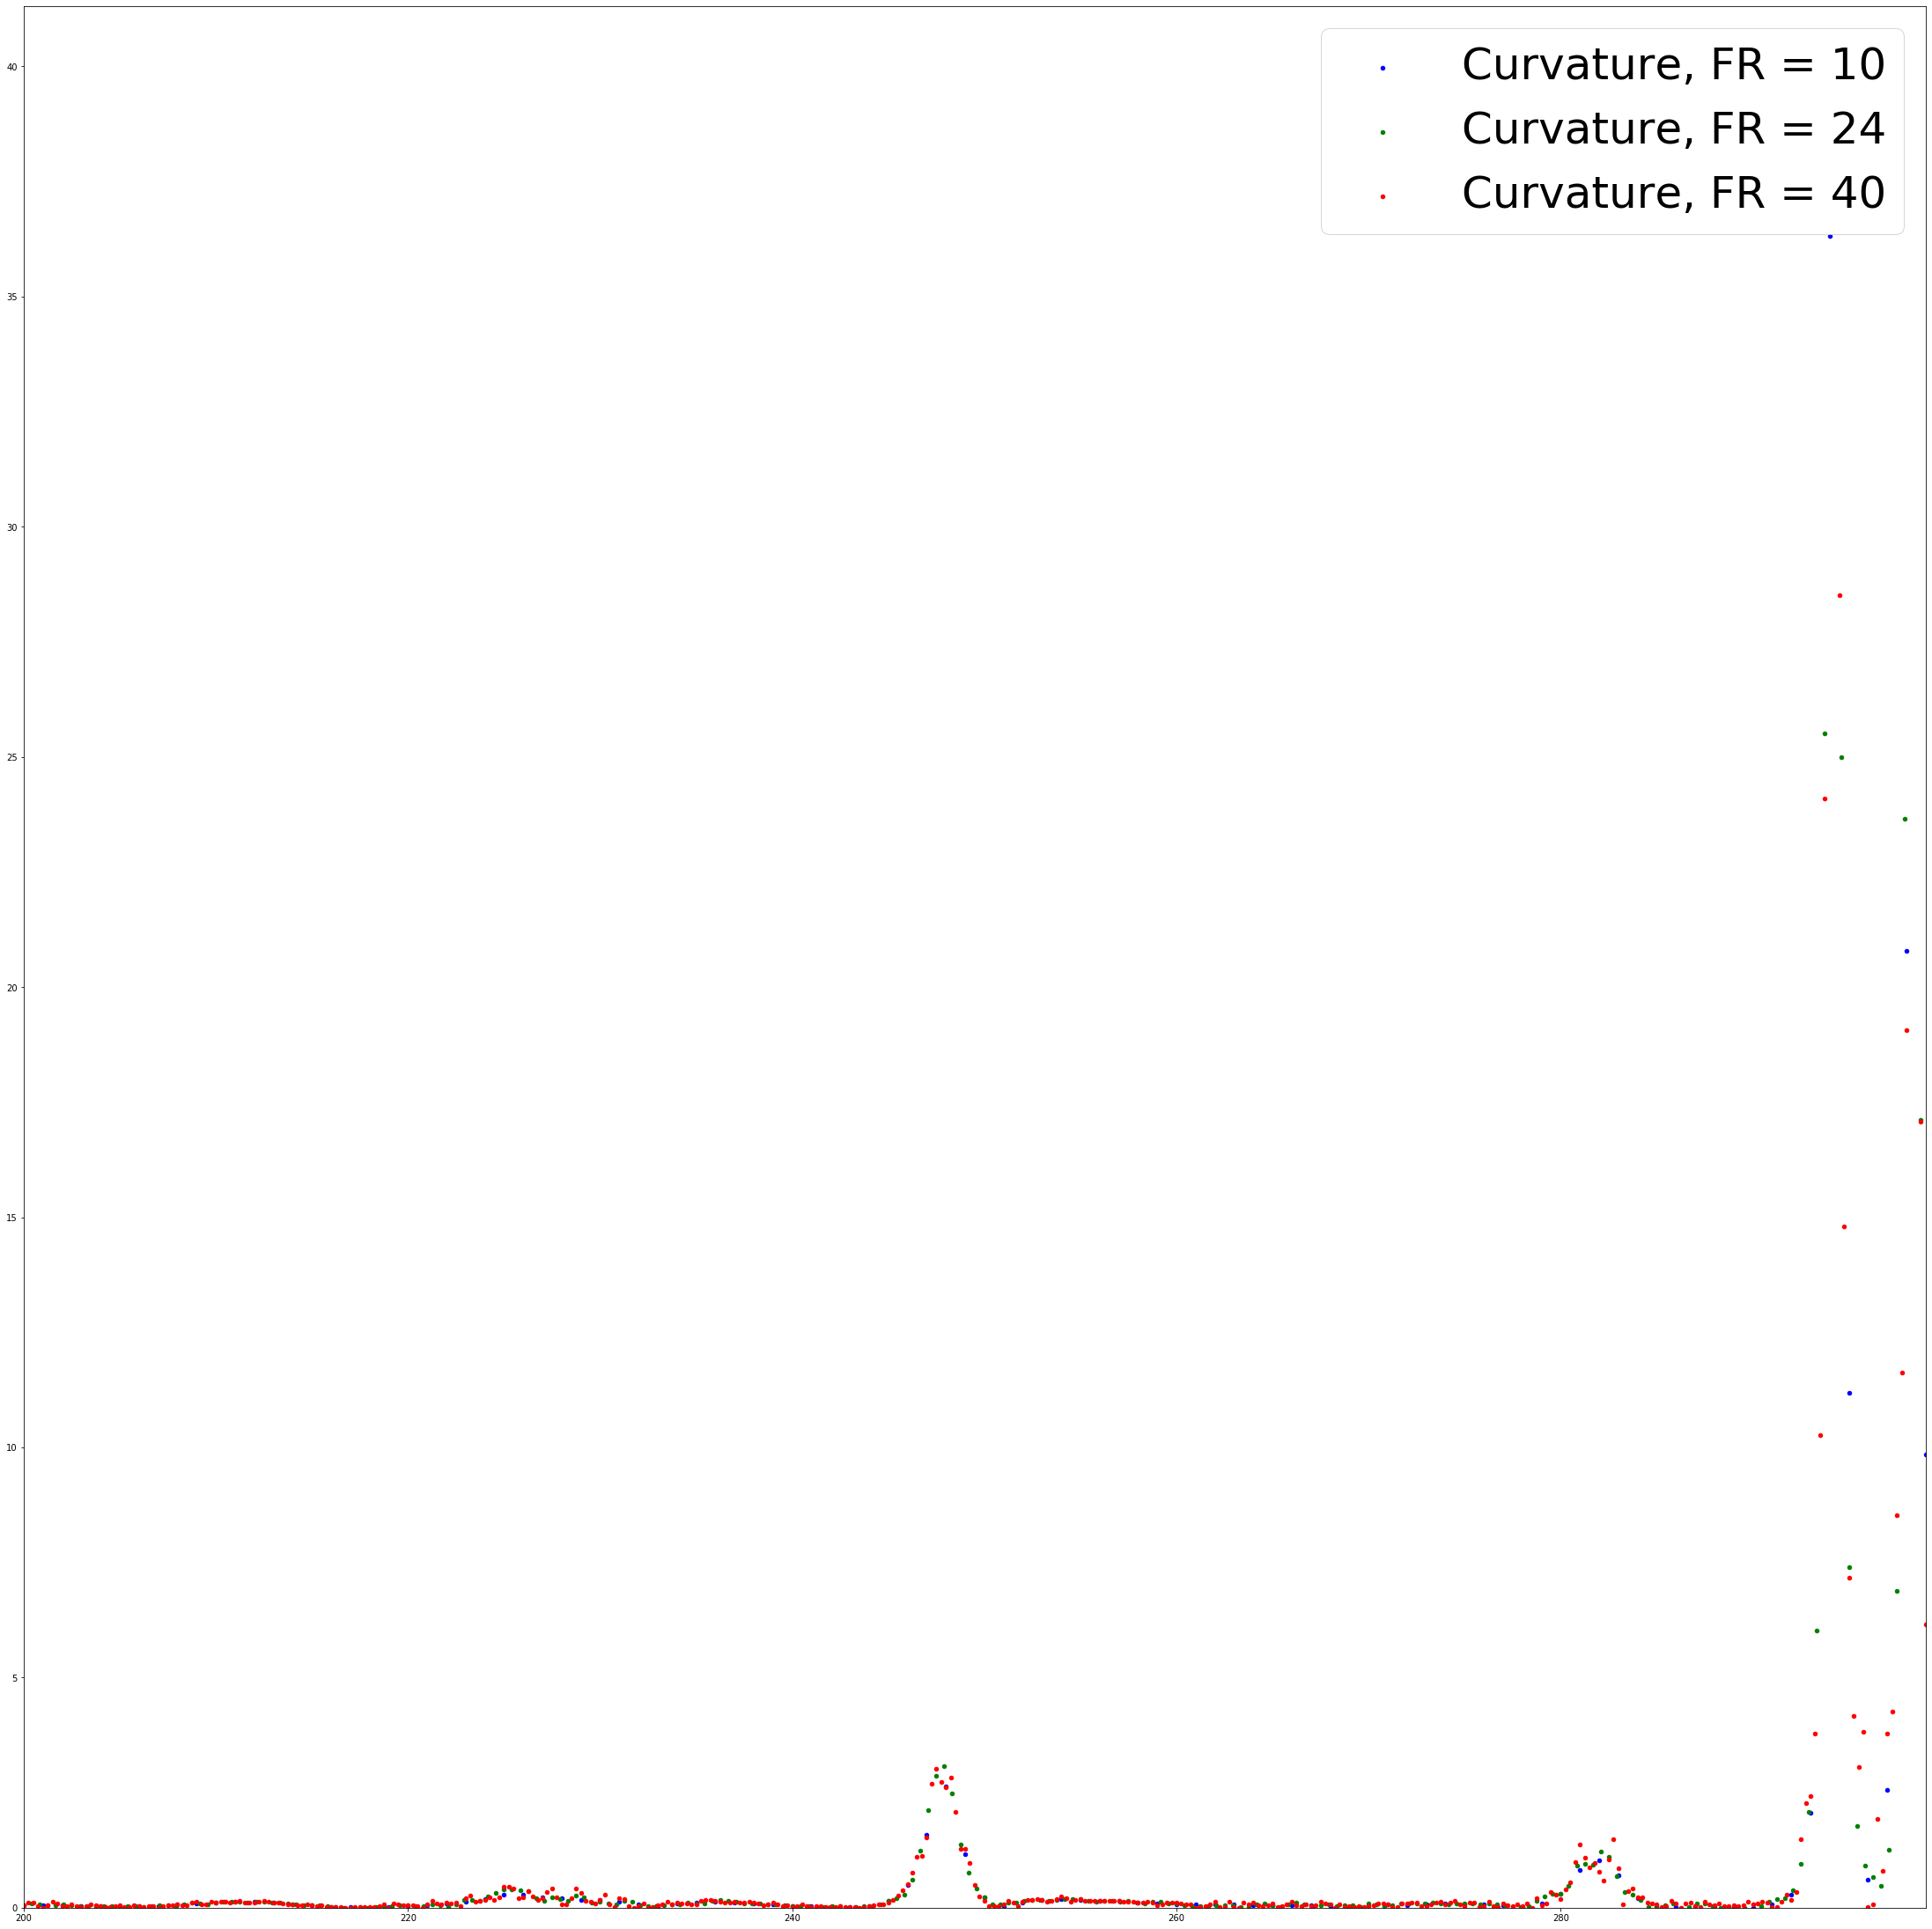

In [19]:
PlotCurveMultiple(1, [10, 24, 40], 3, 1, mode = 'curvature', zoom_range= range(200,300))

LOG: Extracting coordinates for Animal CRV_01_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_01_TEST_00...
LOG: Extracting coordinates for Animal CRV_01_TEST_01...
LOG: Extracting coordinates for Animal CRV_01_TEST_02...
LOG: Extracting coordinates for Animal CRV_01_TEST_03...
LOG: Extracting coordinates for Animal CRV_01_TEST_04...
LOG: Extracting coordinates for Animal CRV_01_TEST_05...
LOG: Extracting coordinates for Animal CRV_01_TEST_06...
LOG: Extracting coordinates for Animal CRV_01_TEST_07...
LOG: Extracting coordinates for Animal CRV_01_TEST_08...
LOG: Extracting coordinates for Animal CRV_01_TEST_09...
LOG: Extracting coordinates for Animal CRV_01_TEST_10...
LOG: Extracting coordinates for Animal CRV_01_TEST_11...
LOG: Extracting coordinates for Animal CRV_01_TEST_12...
LOG: Extracting coordinates for Animal CRV_01_TEST_13...
LOG: Extracting coordinates for Animal CRV_01_TEST_14...
LOG: Extracting coordinates for Animal CRV_01_TEST_15...
LOG: Extracting coordinates f

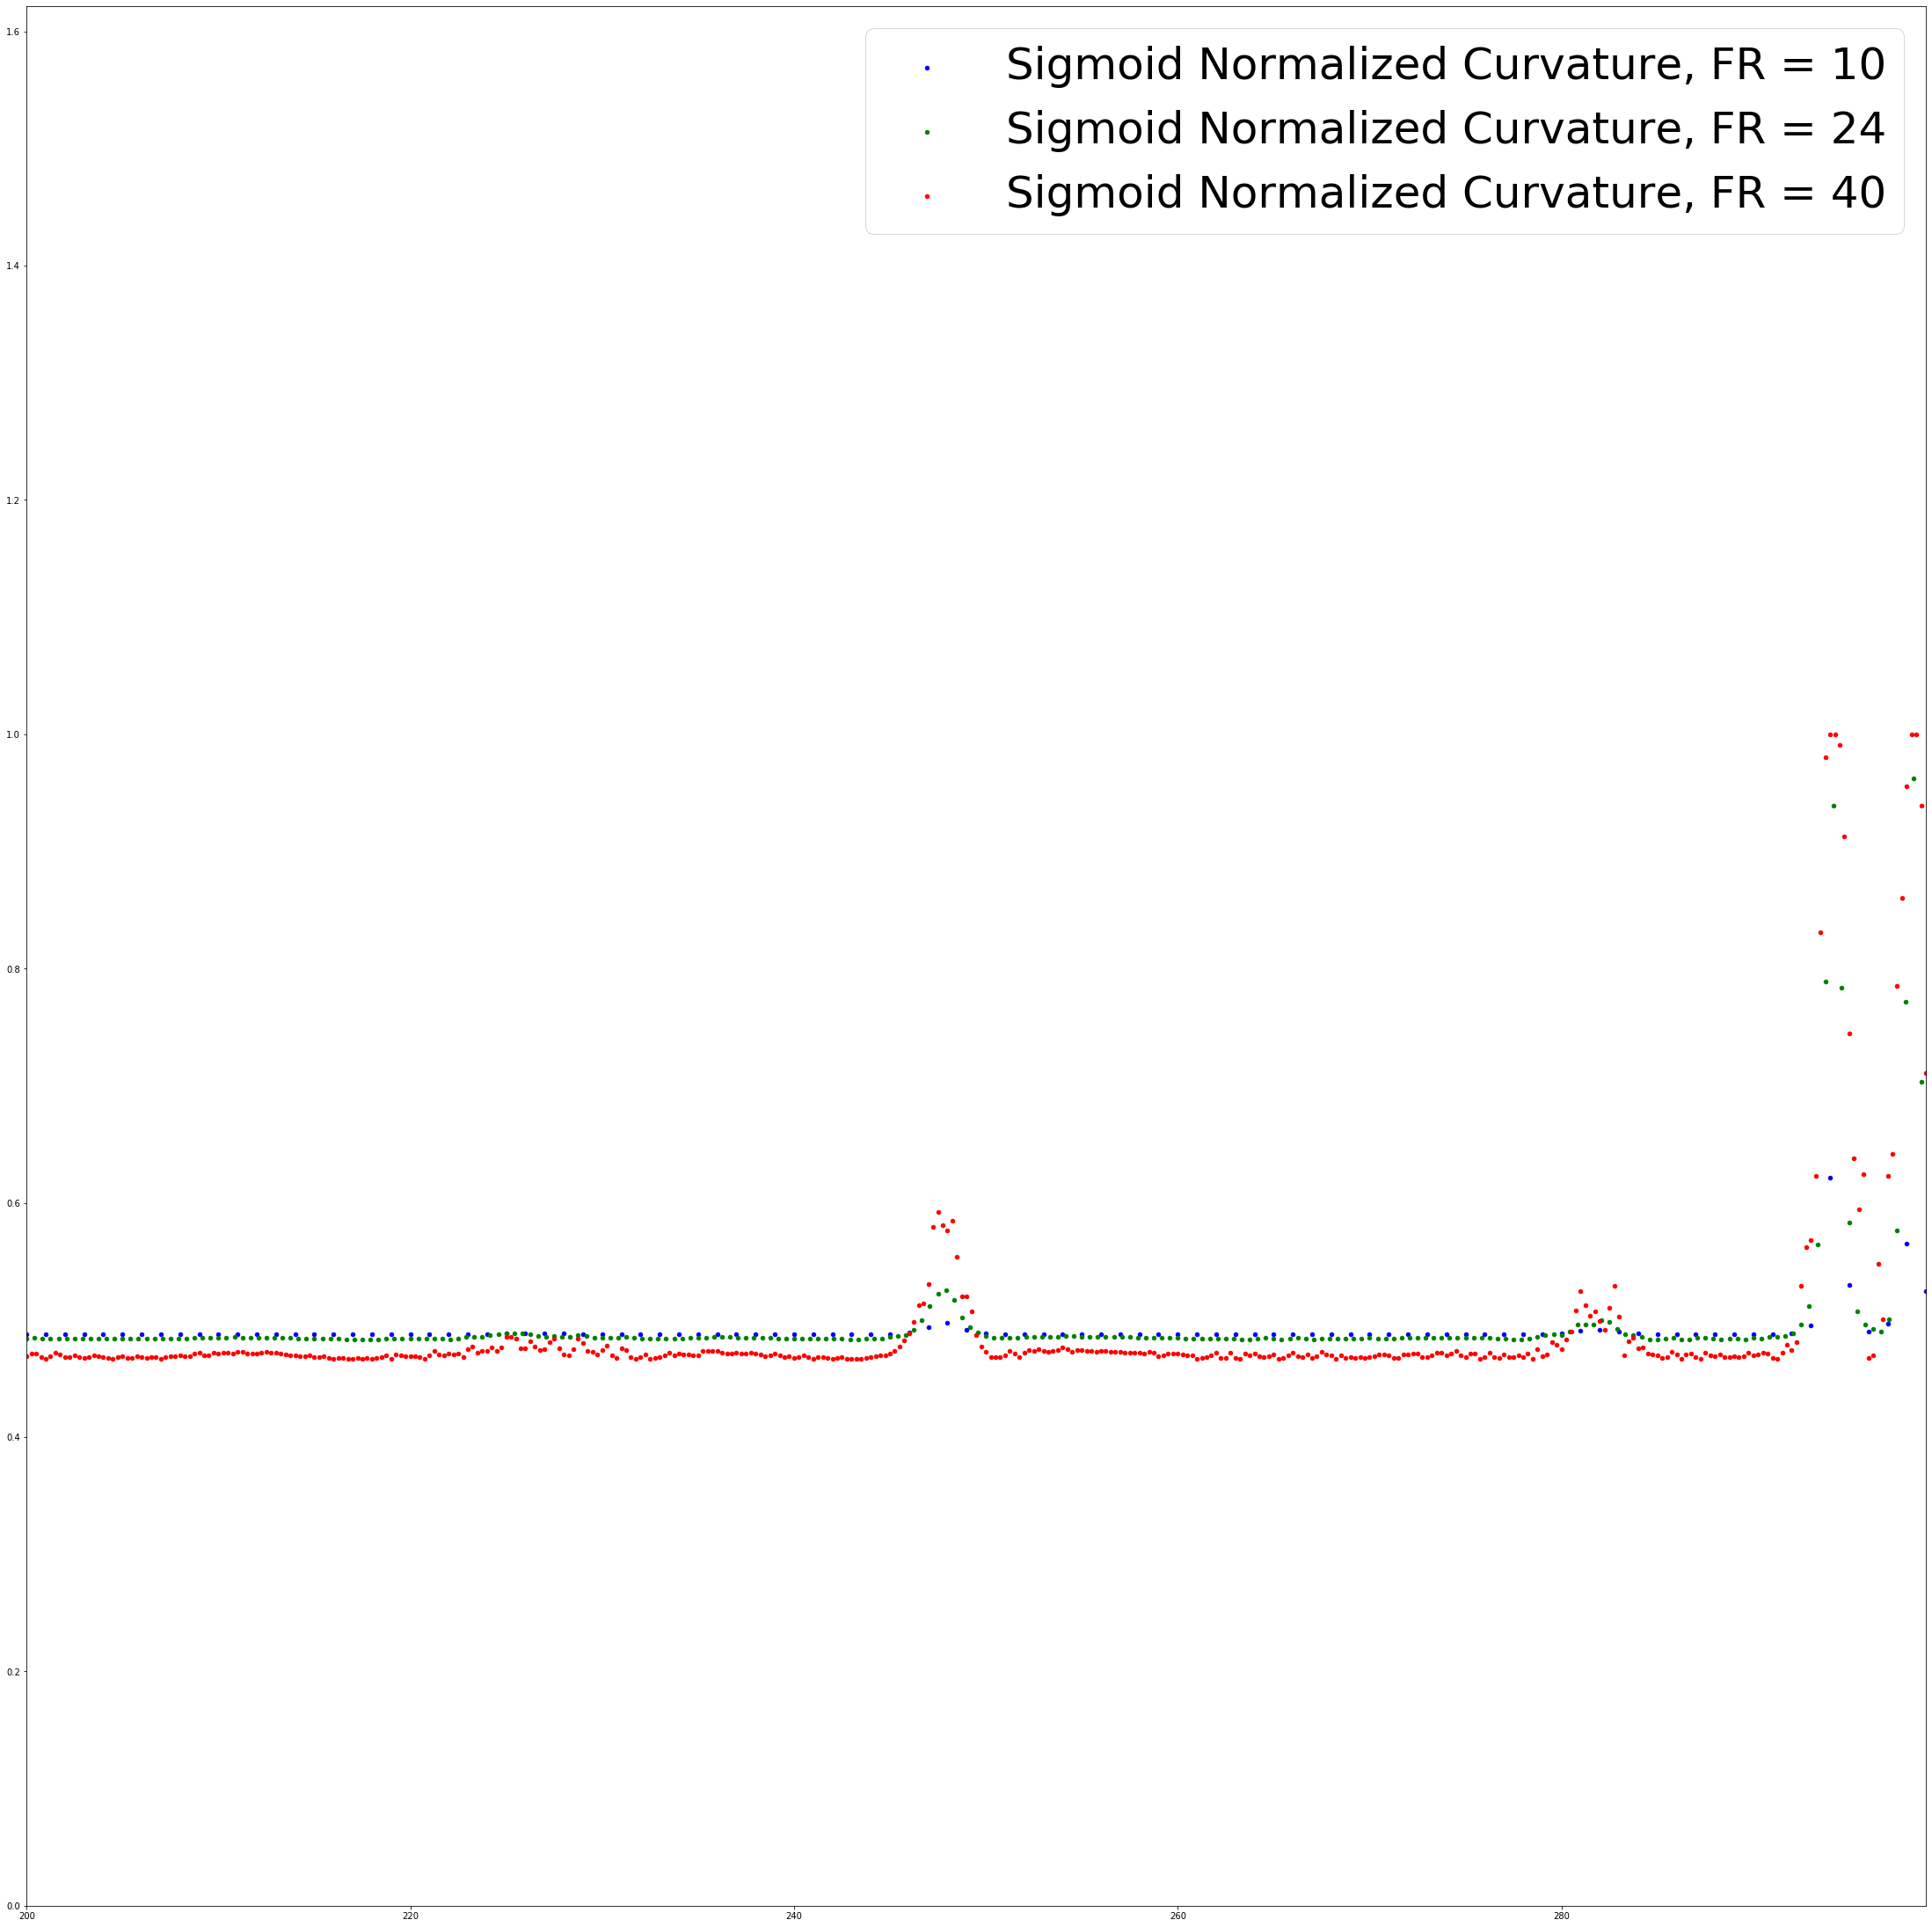

In [20]:
PlotCurveMultiple(1, [10, 24, 40], 3, 1, mode = 'sigmoid normalized curvature', zoom_range= range(200,300))

In [10]:
def GetCurveStats(curve, FR, ORDER, c, mode = 'coords', zoom_range=None):
    

    #plots x and y coordinates of curve (curve) 
    #provide  zoom_in_for_fr2_range to specify the frame range for the extra plot
    #provide extra data to plot: original curve, and curve captured with fr and density
    
    #ORDER: order of the polynomials in Savitzky-Golai smoothing
    #c: window length (in Sav-Gol smoothing) = c * FR
    
    #get animal_obj
    curve_str = '%02d' % curve
    info_file_low = "/Users/karolinagrzeszkiewicz/robustness-tests2/locomotion/tests/robustness_tests/results/FR_test_lower/CRV_"+curve_str+".json"
    info_file_high = "/Users/karolinagrzeszkiewicz/robustness-tests2/locomotion/tests/robustness_tests/results/FR_test_higher/CRV_"+curve_str+".json"
    animals_low = animal.get_animal_objs(info_file_low)
    animals_high = animal.get_animal_objs(info_file_high)
    
    
    if FR in FR_low_sequence:
        test_name = "FR_test_lower"
        idx = FR_low_sequence.index(FR)+1
        animal_obj = animals_low[idx]
    elif FR in FR_high_sequence:
        test_name = "FR_test_higher"
        idx = FR_high_sequence.index(FR)+1
        animal_obj = animals_high[idx]
    
    
    SMOOTH_RANGE_MIN = 5
    #FR = animal_obj.getFrameRate()
    
    #FUNCTIONS FROM TRAJECTORY MODIFIED FOR PLOTTING PURPOSES
    
    def smooth(X, frame_rate):
    # Smoothes the sequence X by applying Savitzky-Golay smoothing
    
        r = max(SMOOTH_RANGE_MIN, int(np.ceil(c*frame_rate)))
        SMOOTH_RANGE = r + 1 if r % 2 == 0 else r
        sX = savgol_filter(X,SMOOTH_RANGE, ORDER)
        return sX
    
    def getCurveData(animal_obj, col_names=None):

        if col_names is None:
            col_names = ['X', 'Y']
        n_dims = len(col_names)
        if n_dims < 2 or n_dims > 3:
            raise Exception("length of col_names is {}, but it should be 2 or 3.".format(n_dims))
        x = animal_obj.get_raw_vals('X') #MM
        y = animal_obj.get_raw_vals('Y') #MM
        coords = []
        for col in col_names:
            try:
                coords.append(smooth(animal_obj.get_raw_vals(col), animal_obj.get_frame_rate()))
            except KeyError:
                raise Exception("column name {} does not exist in animal dataset".format(col))
        coords = np.array(coords) # MM
        d1 = trajectory.get_derivatives(coords, axis=1) # MM per frame
        d1 = d1 * animal_obj.get_frame_rate() # MM per second
        d2 = trajectory.get_derivatives(d1, axis=1) # MM per second per frame
        d2 = d2 * animal_obj.get_frame_rate() # MM per second per second
        V = trajectory.get_velocity(d1)
        C = trajectory.get_curvature(d1, d2, V)

        start_time, end_time = animal_obj.get_baseline_times()
        animal_obj.add_raw_vals('Velocity', V)
        animal_obj.add_stats('Velocity', 'baseline', start_time, end_time)
        animal_obj.add_raw_vals('Curvature', C)
        animal_obj.add_stats('Curvature', 'baseline', start_time, end_time)
        return x, y, coords, d1, d2, V, C

    
        #get data for the original coordinates of the generated curve
    
    #read in data from the corresponding coefficients csv file
    curve_str = '%02d' % curve
    coeff_path = "/Users/karolinagrzeszkiewicz/robustness-tests/locomotion/tests/robustness_tests/data/curve_data/coefficients_"+curve_str+".csv"
    data = pd.read_csv(coeff_path)

    #coefficients - each are sequences of length k
    #a_k, b_k are used for x(theta) and c_k, d_k are used for y(theta)
    a_k = data['a_k'].values
    b_k = data['b_k'].values
    c_k = data['c_k'].values
    d_k = data['d_k'].values

    #extras
    #maximum theta value for input into the trig function
    max_theta = data['extras'][0]
    #size is the full dimensions of the camera, whereas x/y min/max/diff are the corresponding
    #dimensions for the bounding box that will contain the curve. All values currently in mm.
    size = data['extras'][1]
    x_min = data['extras'][2]
    x_max = data['extras'][3]
    x_diff = x_max - x_min
    y_min = data['extras'][4]
    y_max = data['extras'][5]
    y_diff = y_max - y_min

    #calculate total frames
    #total_frames = (time_stop - time_start) * frame_rate
    #partition the interval [0, max_theta] into total_frame steps, generating 1 theta per frame
    #to be used in the parametric function.
    thetas = max_theta * np.arange(0, 1, 1/50000)
    #50 000 instead of frames, must be large enough to get a smooth curves
    #generate trig functions for x, y coordinates. Each function's domain is theta in [0, 2pi]
    x_fun = genTrigFun(a_k, b_k)
    y_fun = genTrigFun(c_k, d_k)

    #calculate x, y coordinates (in mm) using thetas, and calculate min/max for scaling/translation
    x_og = x_fun(thetas)
    y_og = y_fun(thetas)
    lower_xlim = min(x_og)
    upper_xlim = max(x_og)
    lower_ylim = min(y_og)
    upper_ylim = max(y_og)

    #translate and scale the coordinates to fit into the generated bounding box while preserving shape
    x_enlarged = []
    y_enlarged = []
    for i in range(0, 50000):
        x_enlarged.append((x_diff / (upper_xlim - lower_xlim)) * (x_og[i] - lower_xlim) + x_min)
        y_enlarged.append((y_diff / (upper_ylim - lower_ylim)) * (y_og[i] - lower_ylim) + y_min)
        
    
    #obtain relevant data frame for given curve and FR
    
    
    x, y, coords, d1, d2, V, C = getCurveData(animal_obj , col_names = ['X', 'Y'])
    FR = animal_obj.get_frame_rate()

    if zoom_range is None:
        zoom_range = range((FR)*60)
        zoom_in_for_fr_range = range((FR)*60)
    else:
        zoom_in_for_fr_range = zoom_range
        
    low_limit = int(((zoom_in_for_fr_range[0])/(60*FR))*50000)
    high_limit = int(((zoom_in_for_fr_range[-1])/(60*FR))*50000)
    x_enlarged = x_enlarged[low_limit:high_limit]
    y_enlarged = y_enlarged[low_limit:high_limit]
    

    #change the range of frames depending on which time/frame interval we want to zoom in to
    x = x[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    y = y[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    coordsx = coords[0]
    coordsx = coordsx[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    coordsy = coords[1]
    coordsy = coordsy[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    d1x = d1[0]
    d1x = d1x[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    d1y = d1[1]
    d1y = d1y[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    d2x = d2[0]
    d2x = d2x[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    d2y = d2[1]
    d2y = d2y[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    V = V[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    C = C[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    
    if mode == 'coords':
        plt.hist(coords[0], bins = 50)
        plt.show()
        plt.hist(coords[1], bins = 50)
        plt.show()
    elif mode == 'velocity':
        plt.hist(V, bins = 80)
        plt.show()
        plt.boxplot(V)
        plt.show()
        return V
    elif mode == 'curvature':
        plt.hist(C, bins = 80)
        plt.show()
        plt.boxplot(C)
        plt.show()
        return C
    
    
    
    
    

LOG: Extracting coordinates for Animal CRV_02_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_02_TEST_00...
LOG: Extracting coordinates for Animal CRV_02_TEST_01...
LOG: Extracting coordinates for Animal CRV_02_TEST_02...
LOG: Extracting coordinates for Animal CRV_02_TEST_03...
LOG: Extracting coordinates for Animal CRV_02_TEST_04...
LOG: Extracting coordinates for Animal CRV_02_TEST_05...
LOG: Extracting coordinates for Animal CRV_02_TEST_06...
LOG: Extracting coordinates for Animal CRV_02_TEST_07...
LOG: Extracting coordinates for Animal CRV_02_TEST_08...
LOG: Extracting coordinates for Animal CRV_02_TEST_09...
LOG: Extracting coordinates for Animal CRV_02_TEST_10...
LOG: Extracting coordinates for Animal CRV_02_TEST_11...
LOG: Extracting coordinates for Animal CRV_02_TEST_12...
LOG: Extracting coordinates for Animal CRV_02_TEST_13...
LOG: Extracting coordinates for Animal CRV_02_TEST_14...
LOG: Extracting coordinates for Animal CRV_02_TEST_15...
LOG: Extracting coordinates f

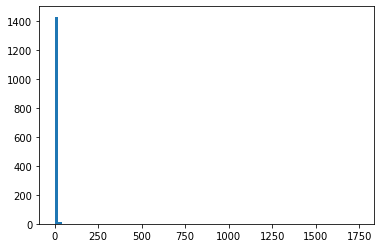

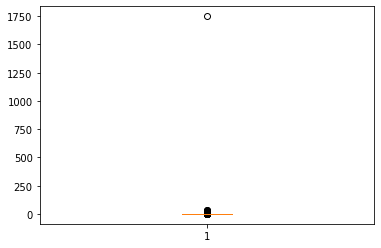

[0.04544500926056803,
 0.06743401562636582,
 0.08823709854670526,
 0.08489559709596853,
 0.08207986158424249,
 0.0797771301896472,
 0.07798568283820421,
 0.07671692498749184,
 0.07599850136905613,
 0.07587898957578108,
 0.07643504970334113,
 0.07937619826068101,
 0.0746641402380487,
 0.09640024855585688,
 0.09893776493259175,
 0.03700459705728384,
 0.13048516374867086,
 0.22484210684840678,
 0.07143149648539787,
 0.02637789421681483,
 0.16015761331659664,
 0.24608736691005414,
 0.12362428064895192,
 0.05876463767256694,
 0.49918269779719043,
 1.1756365529383606,
 3.126889628043615,
 2.864040459323201,
 28.19243389824482,
 1749.3736985305882,
 11.960164775824262,
 0.11125707372370082,
 0.2430417757680471,
 0.3103750232613603,
 0.3373781029481423,
 0.06341383171775296,
 0.3488372661542974,
 0.3497670595101623,
 0.24011804177898452,
 0.09462773311819998,
 0.051215890948539504,
 0.05052008392054316,
 0.06484188266707187,
 0.24110052585508257,
 0.300139377769213,
 0.16222952090662618,
 0.15

In [11]:
GetCurveStats(2, 24, 3, 1, mode = 'curvature')